## Setup

In [1]:
import sys, os
from pyspark.sql.functions import col, lit
import pyspark.sql.functions as F
sys.path.append(os.path.abspath(".."))
from spark_env import spark
from tools.helpers import DFHelpers
import matplotlib.pyplot as plt

Driver is running on local environment


In [2]:
movies_df_raw = (
    spark.table("main.tomes_gen.tmdb_movies_bronze")
        .filter(col("original_language") == "en")
)

In [3]:
helper = DFHelpers(movies_df_raw)

In [4]:
keys = ["id"]
numerical_fields = helper.get_numerical_fields()
continuous_fields = helper.get_continuous_fields(threshold=20, omit_fields=keys)
categorical_fields = helper.get_categorical_fields(threshold=20, omit_fields=keys)

In [5]:
movies_continuous_df = movies_df_raw.select(continuous_fields)
movies_categorical_df = movies_df_raw.select(categorical_fields)
movies_continuous_df_sample = movies_continuous_df.sample(False, 0.1)
movies_categorical_df_sample = movies_categorical_df.sample(False, 0.1)

In [6]:
movies_continuous_df_sample.toPandas()

,popularity,budget,revenue,runtime,vote_average,vote_count
0,717.798,120000000.0,0.000000e+00,128.0,7.464,69.0
1,606.721,100000000.0,1.355725e+09,93.0,7.795,6262.0
2,581.299,0.0,0.000000e+00,94.0,3.900,13.0
3,386.396,0.0,0.000000e+00,83.0,6.800,11.0
4,355.664,0.0,0.000000e+00,127.0,6.643,77.0
...,...,...,...,...,...,...
36019,0.600,0.0,0.000000e+00,25.0,3.000,1.0
36020,0.600,0.0,0.000000e+00,50.0,0.000,0.0
36021,0.600,0.0,0.000000e+00,0.0,0.000,0.0
36022,0.600,0.0,0.000000e+00,33.0,0.000,0.0


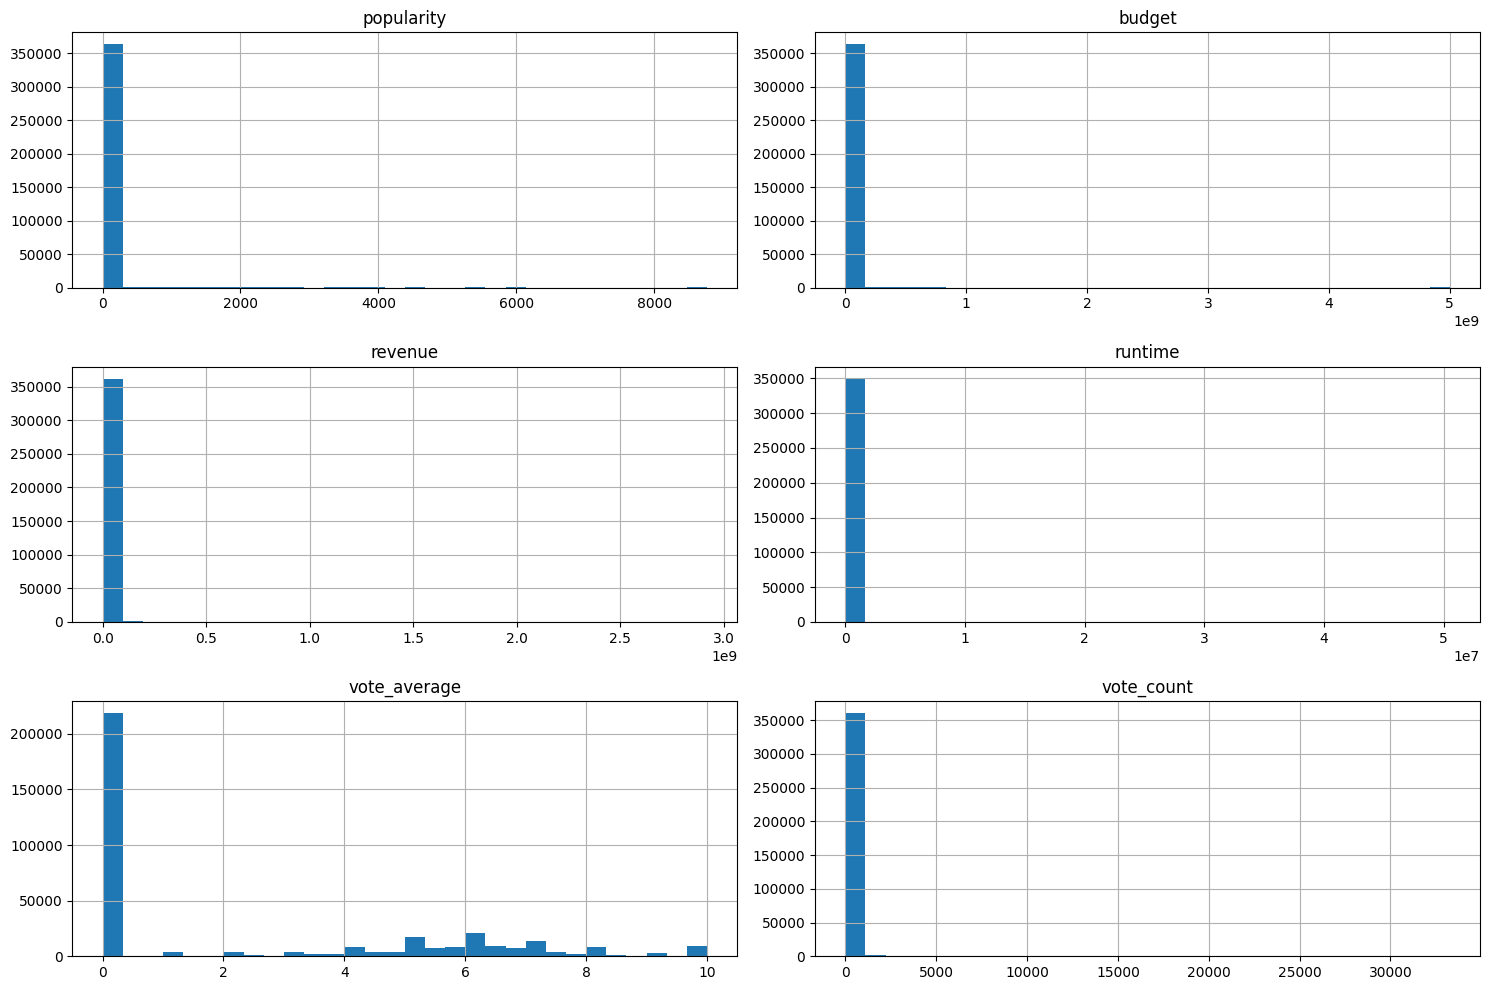

In [7]:
# Convert Spark DataFrame to Pandas DataFrame
movies_continuous_pd = movies_continuous_df.toPandas()

# Plot histograms for each column
movies_continuous_pd.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

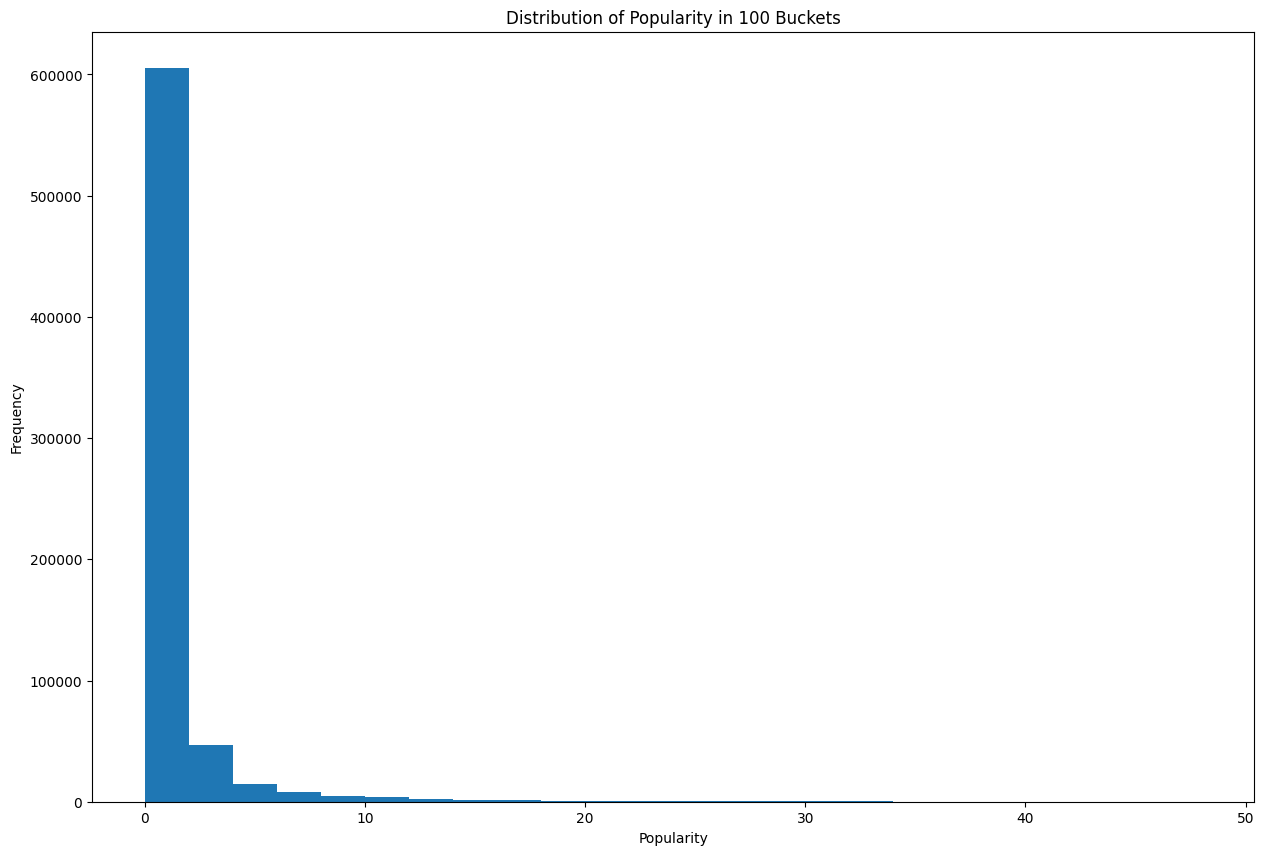

In [23]:
# Show the distribution of 'popularity' in 100 buckets where each bucket increments by 5
movies_continuous_pd['popularity'].plot(kind='hist', bins=range(0, 50, 2), figsize=(15, 10))
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Distribution of Popularity in 100 Buckets')
plt.show()

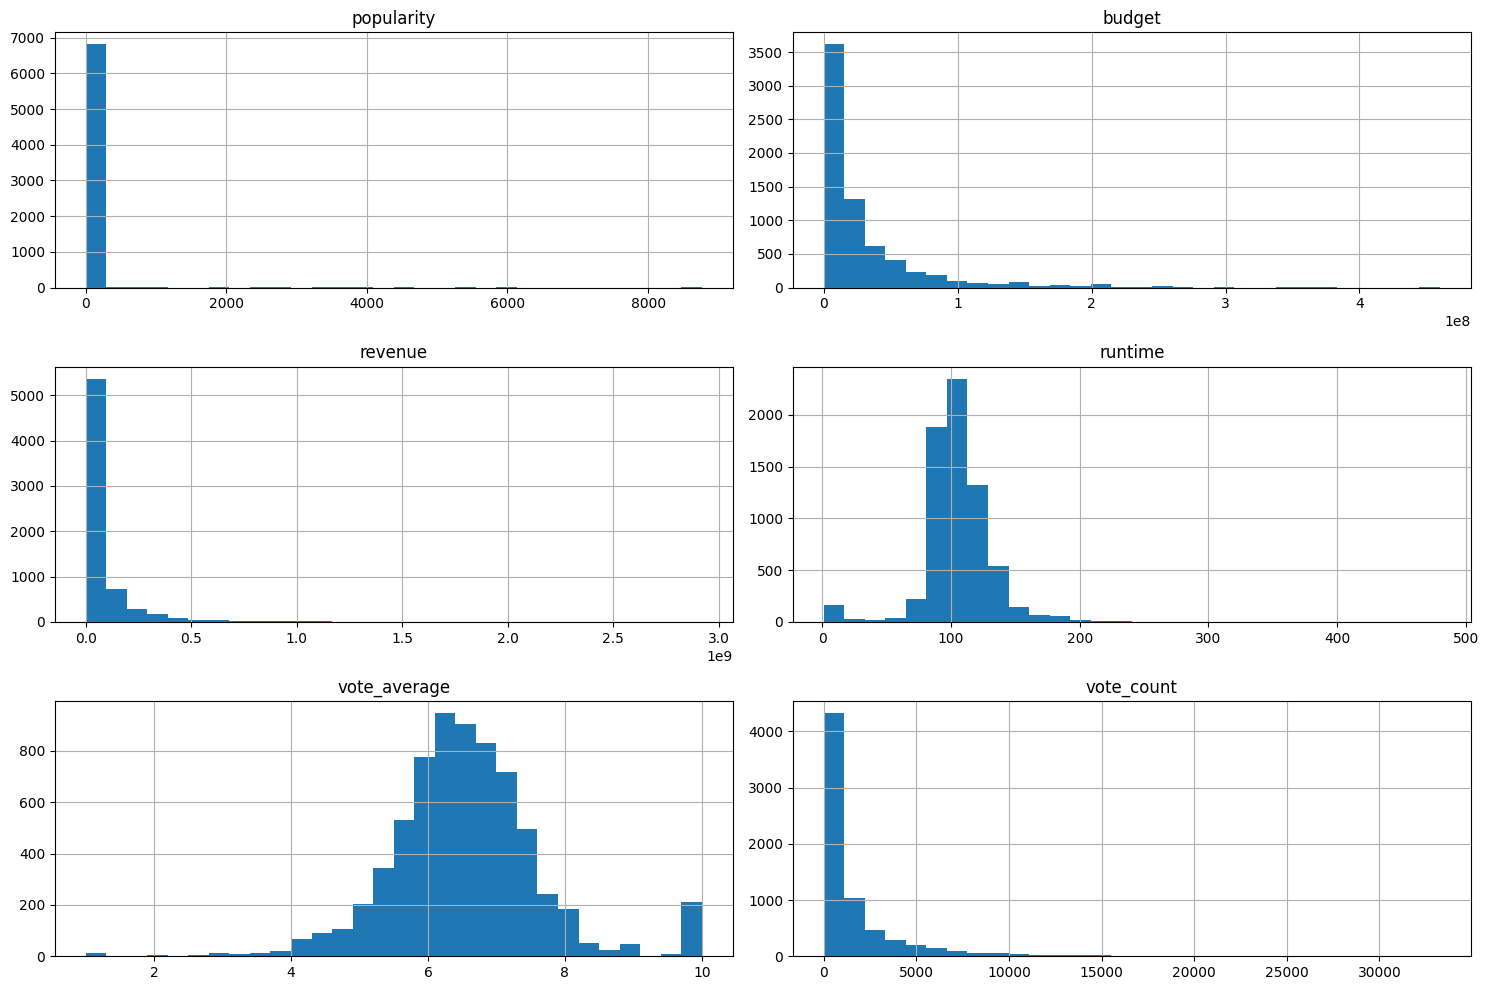

In [6]:
movies_continuous_df = movies_continuous_df.filter(helper.fields_global_filter_op(continuous_fields, "gt", 0))
# Convert Spark DataFrame to Pandas DataFrame
movies_continuous_pd = movies_continuous_df.toPandas()

# Plot histograms for each column
movies_continuous_pd.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


In [7]:
cont_fields_filters = {
    "vote_count": {
        "op": "gt",
        "threshold": 1000
    },
    "popularity": {
        "op": "between",
        "threshold": [10, 6500]
    },
    "vote_average": {
        "op": "between",
        "threshold": [4,9.9]
    },
    "revenue": {
        "op": "gt",
        "threshold": 200_000
    },
    "budget": {
        "op": "gt",
        "threshold": 200_000
    },
    "runtime": {
        "op": "between",
        "threshold": [60, 400]
    }
}

In [24]:
tdf = helper.apply_df_filters(movies_continuous_df, cont_fields_filters, watch_filter=True)

Field: vote_count, Count after filter: 3033
Field: popularity, Count after filter: 2981
Field: vote_average, Count after filter: 2977
Field: revenue, Count after filter: 2714
Field: budget, Count after filter: 2610
Field: runtime, Count after filter: 2610


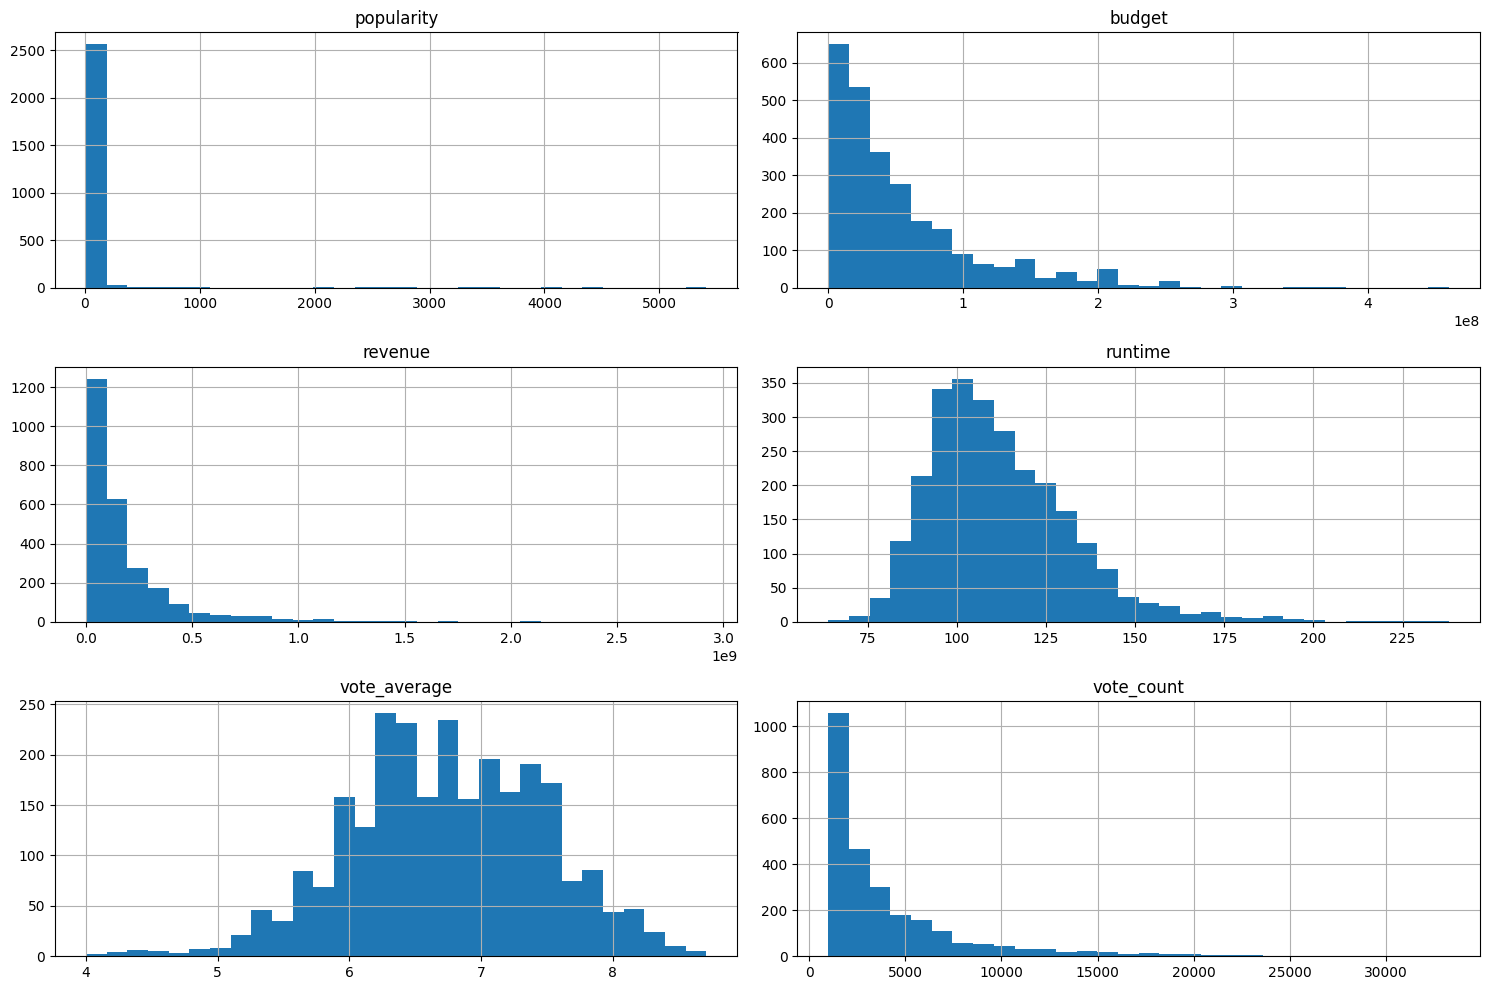

In [8]:
movies_continuous_no_outliers_df = helper.apply_df_filters(movies_continuous_df, cont_fields_filters)
# Convert Spark DataFrame to Pandas DataFrame
movies_continuous_no_outliers_pd = movies_continuous_no_outliers_df.toPandas()

# Plot histograms for each column
movies_continuous_no_outliers_pd.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


In [9]:
movies_continuous_no_outliers_df = helper.scale_fields(movies_continuous_no_outliers_df, ["popularity"])

AssertionError: 

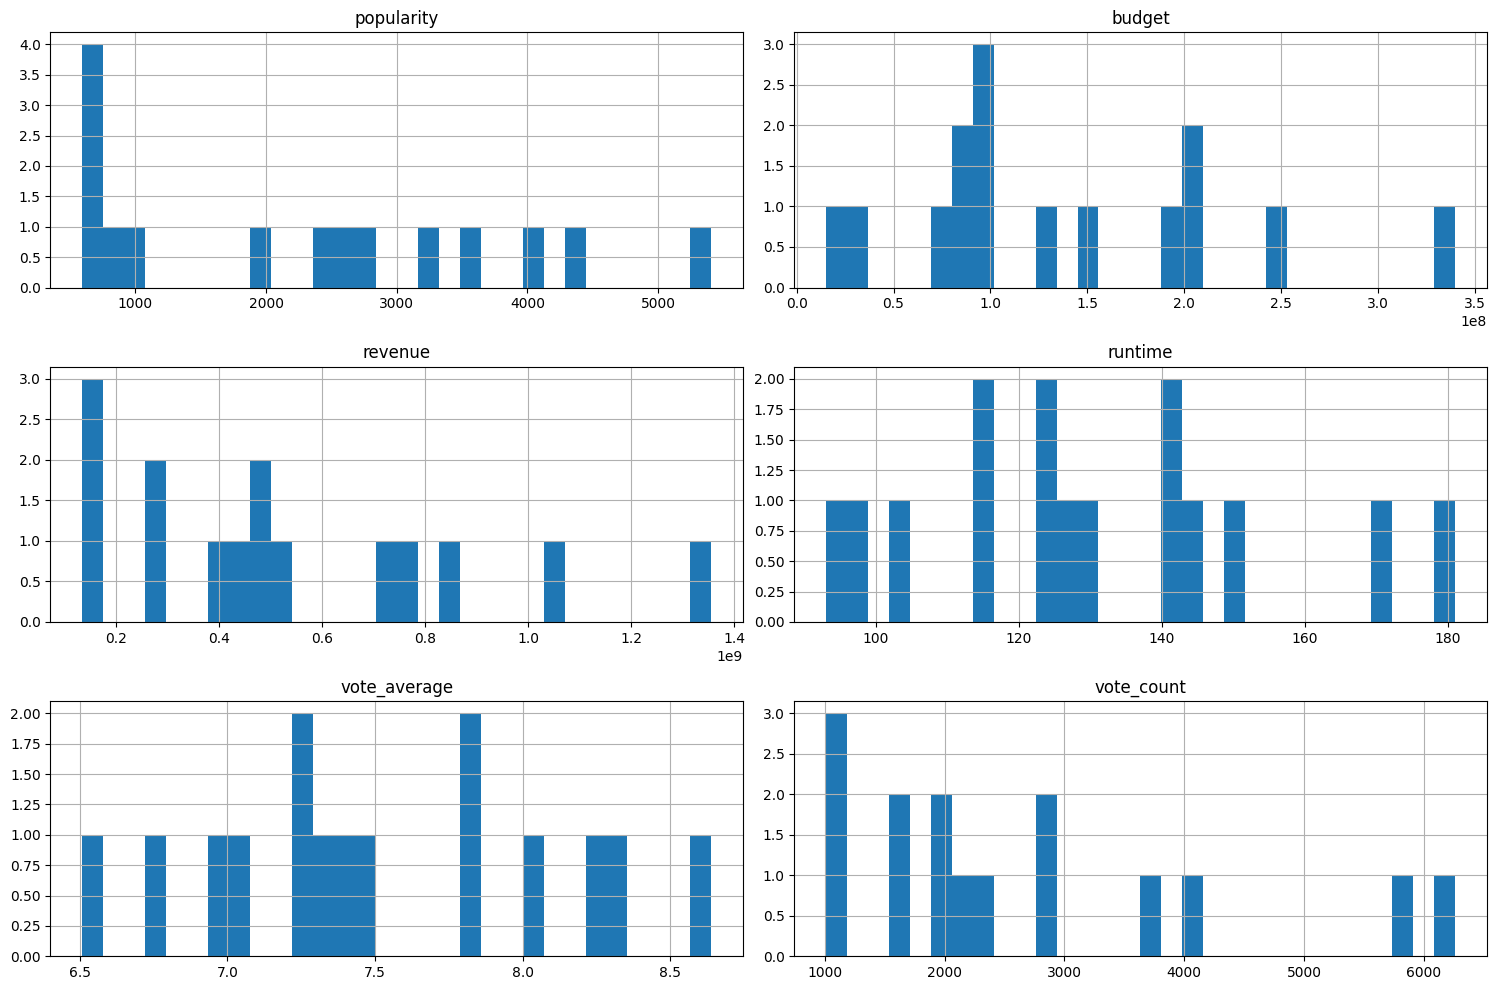

In [19]:
test = movies_continuous_df.filter(helper.field_by_op_filter(cont_fields_filters))
# Convert Spark DataFrame to Pandas DataFrame
test_pd = test.toPandas()

# Plot histograms for each column
test_pd.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()
